In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import ipaddress
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 1. Cargamos el modelo, la GAN y los datos

In [55]:
classifier = load_model("modelo_principal.keras")

In [56]:
classifier_reinforced = load_model("modelo_reentrenado.keras")

In [57]:
dataset = pd.read_csv("X_filtered.csv")

In [58]:
def custom_generator_loss(y_true, y_pred, generated_data, alpha=0.2, target_mean=0.3):
    # Pérdida adversarial normal (engañar al clasificador)
    adv_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(y_pred), y_pred))

    # Penalización: queremos que la media por columna sea cercana a un cierto valor
    mean_per_col = tf.reduce_mean(generated_data, axis=0)
    mean_loss = tf.reduce_mean(tf.nn.relu(target_mean - mean_per_col))  # penaliza solo si está por debajo

    # Combinar las pérdidas
    return adv_loss + alpha * mean_loss

# Cargar el modelo indicando la función personalizada
gan = load_model("gan.keras", custom_objects={"adversarial_loss": custom_generator_loss})
generator = load_model("generator.keras")

c:\Users\samue\anaconda3\envs\tensorflow_env\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\samue\anaconda3\envs\tensorflow_env\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 38 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## 2. Generamos muestras sintéticas adversarias

In [59]:
input_dim = 90
nuevos_datos_generados = generator.predict(np.random.normal(0, 1, (100000, input_dim)))
nuevos_datos_generados = pd.DataFrame(nuevos_datos_generados, columns= dataset.drop(columns= "Target").columns)
original_preds = classifier.predict(nuevos_datos_generados)
reinforced_preds = classifier_reinforced.predict(nuevos_datos_generados)
clases_modelo_original = (original_preds > 0.5).astype(int)
clases_modelo_reentrenado = (reinforced_preds > 0.5).astype(int)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


## 3. Predicciones

In [60]:
pd.DataFrame(clases_modelo_original).value_counts()

0
0    99958
1       42
Name: count, dtype: int64

In [61]:
pd.DataFrame(clases_modelo_reentrenado).value_counts()

0
1    100000
Name: count, dtype: int64

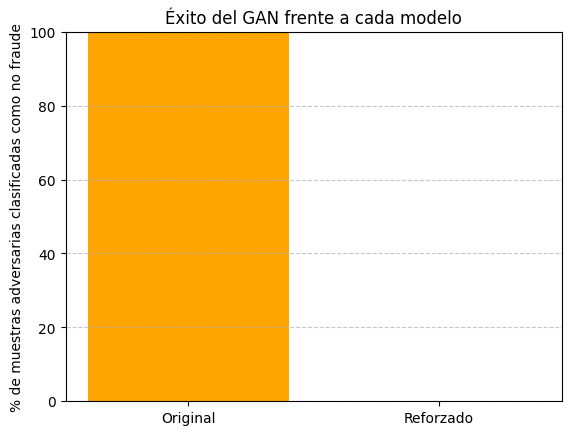

In [62]:
original_success_rate = np.mean(clases_modelo_original == 0)  # porcentaje de muestras clasificadas como "no fraude"
reinforced_success_rate = np.mean(clases_modelo_reentrenado == 0)

labels = ["Original", "Reforzado"]
values = [original_success_rate * 100, reinforced_success_rate * 100]

plt.figure()
plt.bar(labels, values, color=['orange', 'green'])
plt.ylabel("% de muestras adversarias clasificadas como no fraude")
plt.title("Éxito del GAN frente a cada modelo")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

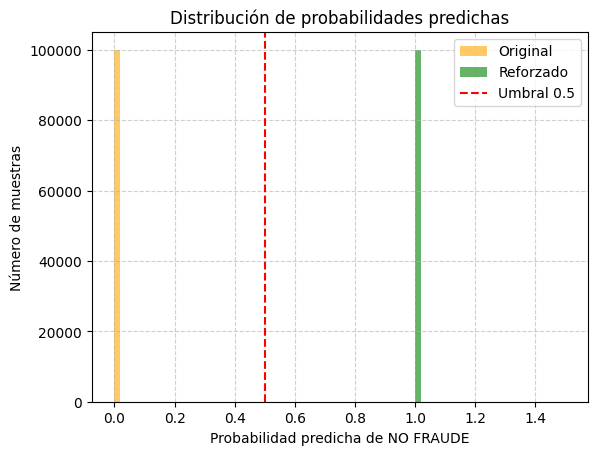

In [63]:
plt.hist(clases_modelo_original, bins=50, alpha=0.6, label='Original', color='orange')
plt.hist(clases_modelo_reentrenado, bins=50, alpha=0.6, label='Reforzado', color='green')
plt.axvline(0.5, color='red', linestyle='--', label='Umbral 0.5')
plt.xlabel("Probabilidad predicha de NO FRAUDE")
plt.ylabel("Número de muestras")
plt.title("Distribución de probabilidades predichas")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

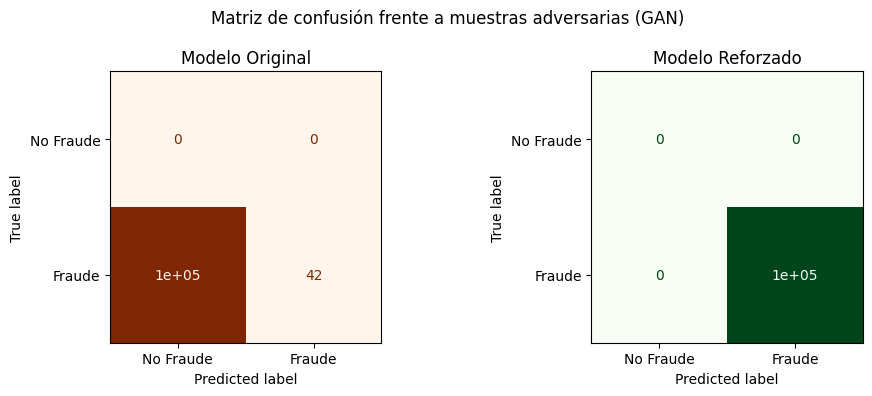

In [64]:
# Asumimos que el label verdadero es 1 (fraude) para todos los ejemplos del GAN
true_labels = np.ones(len(nuevos_datos_generados))

# Forzamos que se consideren ambas clases: 0 = No Fraude, 1 = Fraude
cm_orig = confusion_matrix(true_labels, clases_modelo_original, labels=[0, 1])
cm_rein = confusion_matrix(true_labels, clases_modelo_reentrenado, labels=[0, 1])

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay(cm_orig, display_labels=["No Fraude", "Fraude"]).plot(ax=axs[0], cmap="Oranges", colorbar=False)
axs[0].set_title("Modelo Original")

ConfusionMatrixDisplay(cm_rein, display_labels=["No Fraude", "Fraude"]).plot(ax=axs[1], cmap="Greens", colorbar=False)
axs[1].set_title("Modelo Reforzado")

plt.suptitle("Matriz de confusión frente a muestras adversarias (GAN)")
plt.tight_layout()
plt.show()


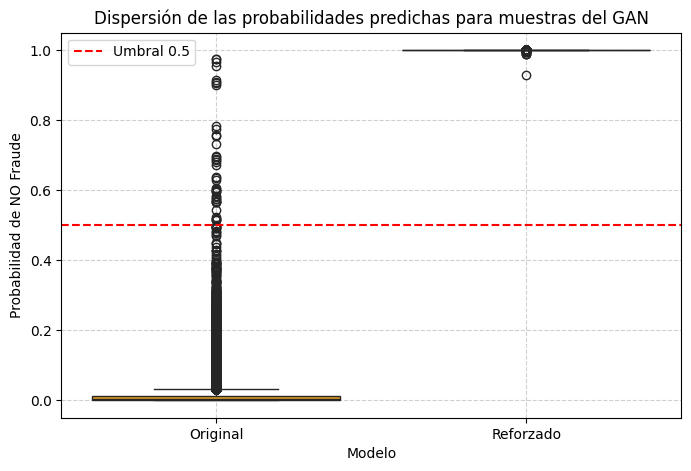

In [65]:
df = pd.DataFrame({
    "Modelo": ["Original"] * len(original_preds) + ["Reforzado"] * len(reinforced_preds),
    "Probabilidad de NO Fraude": np.concatenate([original_preds, reinforced_preds]).flatten()
})

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Modelo", y="Probabilidad de NO Fraude", hue="Modelo", palette=["orange", "green"], legend=False)
plt.axhline(0.5, linestyle="--", color="red", label="Umbral 0.5")
plt.title("Dispersión de las probabilidades predichas para muestras del GAN")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

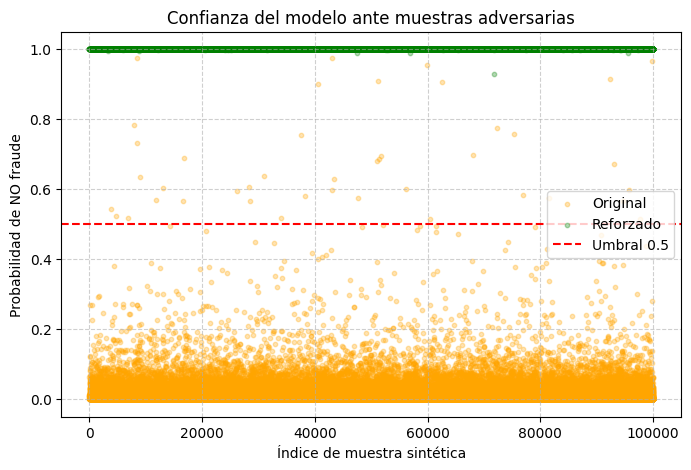

In [66]:
plt.figure(figsize=(8, 5))
plt.scatter(range(len(original_preds)), original_preds, alpha=0.3, label="Original", color="orange", s=10)
plt.scatter(range(len(reinforced_preds)), reinforced_preds, alpha=0.3, label="Reforzado", color="green", s=10)
plt.axhline(0.5, color="red", linestyle="--", label="Umbral 0.5")
plt.title("Confianza del modelo ante muestras adversarias")
plt.xlabel("Índice de muestra sintética")
plt.ylabel("Probabilidad de NO fraude")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

## 4. Ampliamos el rango

In [67]:
nuevos_datos_generados = generator.predict(np.random.normal(0, 2, (100000, input_dim)))
nuevos_datos_generados = pd.DataFrame(nuevos_datos_generados, columns= dataset.drop(columns= "Target").columns)
original_preds = classifier.predict(nuevos_datos_generados)
reinforced_preds = classifier_reinforced.predict(nuevos_datos_generados)
clases_modelo_original = (original_preds > 0.5).astype(int)
clases_modelo_reentrenado = (reinforced_preds > 0.5).astype(int)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


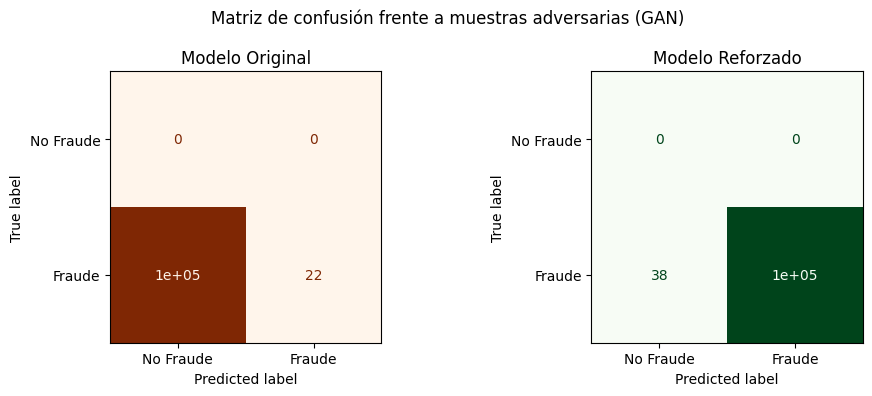

In [68]:
# Asumimos que el label verdadero es 1 (fraude) para todos los ejemplos del GAN
true_labels = np.ones(len(nuevos_datos_generados))

# Forzamos que se consideren ambas clases: 0 = No Fraude, 1 = Fraude
cm_orig = confusion_matrix(true_labels, clases_modelo_original, labels=[0, 1])
cm_rein = confusion_matrix(true_labels, clases_modelo_reentrenado, labels=[0, 1])

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay(cm_orig, display_labels=["No Fraude", "Fraude"]).plot(ax=axs[0], cmap="Oranges", colorbar=False)
axs[0].set_title("Modelo Original")

ConfusionMatrixDisplay(cm_rein, display_labels=["No Fraude", "Fraude"]).plot(ax=axs[1], cmap="Greens", colorbar=False)
axs[1].set_title("Modelo Reforzado")

plt.suptitle("Matriz de confusión frente a muestras adversarias (GAN)")
plt.tight_layout()
plt.show()


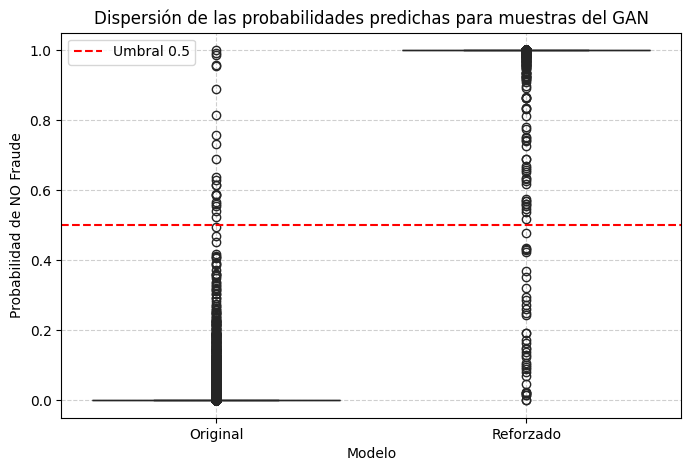

In [69]:
df = pd.DataFrame({
    "Modelo": ["Original"] * len(original_preds) + ["Reforzado"] * len(reinforced_preds),
    "Probabilidad de NO Fraude": np.concatenate([original_preds, reinforced_preds]).flatten()
})

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Modelo", y="Probabilidad de NO Fraude", hue="Modelo", palette=["orange", "green"], legend=False)
plt.axhline(0.5, linestyle="--", color="red", label="Umbral 0.5")
plt.title("Dispersión de las probabilidades predichas para muestras del GAN")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

c:\Users\samue\anaconda3\envs\tensorflow_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


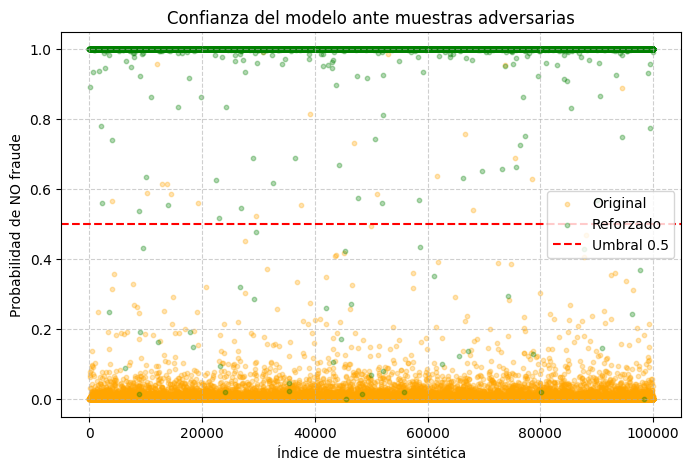

In [70]:
plt.figure(figsize=(8, 5))
plt.scatter(range(len(original_preds)), original_preds, alpha=0.3, label="Original", color="orange", s=10)
plt.scatter(range(len(reinforced_preds)), reinforced_preds, alpha=0.3, label="Reforzado", color="green", s=10)
plt.axhline(0.5, color="red", linestyle="--", label="Umbral 0.5")
plt.title("Confianza del modelo ante muestras adversarias")
plt.xlabel("Índice de muestra sintética")
plt.ylabel("Probabilidad de NO fraude")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()